<a href="https://colab.research.google.com/github/gowthami9821/Group_AM/blob/main/Drug_Discovery_Diffusion_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
print(pd.__version__)
print(np.__version__)

2.2.2
2.0.2


# New Section

In [ ]:
!pip uninstall -y numpy pandas

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2


In [ ]:
!pip install numpy==1.26.4 pandas==2.2.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 60.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
import numpy as np

print(np.__version__)


1.26.4


In [ ]:
!pip install rdkit >& dev_null

In [ ]:
!pip install rdkit-pypi tqdm matplotlib
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 33.8 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv('SMILES_Big_Data_Set.csv')
smiles_list = df['SMILES'].dropna().unique()[:10000]

In [ ]:
df.head()

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


In [ ]:
# df = pd.read_csv('/content/SMILES_Big_Data_Set.csv')
# smiles_list = df['SMILES'].dropna().unique()[:10000]  # Limit for training speed


def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        return np.array(fp)
    return None

fingerprints = []
for s in tqdm(smiles_list):
    fp = smiles_to_fp(s)
    if fp is not None:
        fingerprints.append(fp)

fingerprints = np.array(fingerprints)
print(f'Valid fingerprints: {fingerprints.shape}')

def q_sample(x_start, t, noise):
    return x_start * (1 - t) + noise * t

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

betas = linear_beta_schedule(1000)


class SimpleDiffusionModel(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=1024):
        super(SimpleDiffusionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        # Add time step embedding (optional for now)
        return self.net(x)


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model and move it to device
model = SimpleDiffusionModel().to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()


def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

timesteps = 1000
betas = linear_beta_schedule(timesteps)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

def forward_diffusion_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alphas_cumprod_t = alphas_cumprod[t]**0.5
    sqrt_one_minus_alphas_cumprod_t = (1 - alphas_cumprod[t])**0.5
    return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise, noise


100%|██████████| 10000/10000 [00:19<00:00, 514.07it/s]


Valid fingerprints: (10000, 2048)


In [ ]:
# Convert your fingerprint data (NumPy) to PyTorch tensors
fingerprint_tensor = torch.tensor(fingerprints, dtype=torch.float32)

# Create a DataLoader for mini-batch training
dataset = TensorDataset(fingerprint_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [ ]:
def forward_diffusion_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alphas_cumprod_t = alphas_cumprod[t].unsqueeze(1).to(x0.device) ** 0.5
    sqrt_one_minus_alphas_cumprod_t = (1 - alphas_cumprod[t]).unsqueeze(1).to(x0.device) ** 0.5

    return sqrt_alphas_cumprod_t * x0 + sqrt_one_minus_alphas_cumprod_t * noise, noise


In [ ]:
from tqdm import tqdm  # ✅ Make sure this line is separate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 10
for epoch in range(epochs):
    print(f"🌟 Epoch {epoch + 1}/{epochs}")
    pbar = tqdm(dataloader)

    for batch in pbar:
        x0 = batch[0].to(device)

        # Random time step for each sample
        t = torch.randint(0, timesteps, (x0.shape[0],), device=device).long()

        # Forward diffusion: add noise to x0
        noisy_x, noise = forward_diffusion_sample(x0, t)

        # Predict the noise using the model
        noise_pred = model(noisy_x, t)

        # Loss: MSE between actual and predicted noise
        loss = mse(noise, noise_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Loss: {loss.item():.4f}")
# save model
torch.save(model.state_dict(), "diffusion_model.pth")
print("✅ Model saved as diffusion_model.pth")

🌟 Epoch 1/10


Loss: 0.9457: 100%|██████████| 157/157 [00:13<00:00, 12.00it/s]


🌟 Epoch 2/10


Loss: 0.9331: 100%|██████████| 157/157 [00:12<00:00, 12.21it/s]


🌟 Epoch 3/10


Loss: 0.9056: 100%|██████████| 157/157 [00:13<00:00, 11.22it/s]


🌟 Epoch 4/10


Loss: 0.9142: 100%|██████████| 157/157 [00:13<00:00, 12.04it/s]


🌟 Epoch 5/10


Loss: 0.9190: 100%|██████████| 157/157 [00:23<00:00,  6.60it/s]


🌟 Epoch 6/10


Loss: 0.9338: 100%|██████████| 157/157 [00:22<00:00,  6.99it/s]


🌟 Epoch 7/10


Loss: 0.9092: 100%|██████████| 157/157 [00:20<00:00,  7.53it/s]


🌟 Epoch 8/10


Loss: 0.9140: 100%|██████████| 157/157 [00:22<00:00,  6.83it/s]


🌟 Epoch 9/10


Loss: 0.9075: 100%|██████████| 157/157 [00:23<00:00,  6.61it/s]


🌟 Epoch 10/10


Loss: 0.9120: 100%|██████████| 157/157 [00:20<00:00,  7.51it/s]

✅ Model saved as diffusion_model.pth


In [ ]:
@torch.no_grad()
def sample(model, n_samples, n_steps, device="cpu"):
    model.eval()
    x = torch.randn(n_samples, 2048).to(device)

    for t in reversed(range(n_steps)):
        t_batch = torch.full((n_samples,), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_batch)

        alpha = alphas[t]
        alpha_hat = alphas_cumprod[t]
        beta = betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / alpha**0.5) * (x - ((1 - alpha) / (1 - alpha_hat)**0.5) * predicted_noise) + (beta**0.5) * noise

    return x


In [ ]:
from rdkit import DataStructs

def nearest_smiles_from_fp(fp_generated, fps_real, smiles_list):
    closest_smiles = []
    for fp in fp_generated:
        sims = [DataStructs.TanimotoSimilarity(DataStructs.ExplicitBitVect(list(fp.cpu().numpy().astype(int))),
                                               DataStructs.ExplicitBitVect(list(rfp.astype(int))))
                for rfp in fps_real]
        best_idx = np.argmax(sims)
        closest_smiles.append(smiles_list[best_idx])
    return closest_smiles


In [ ]:
T = 1000
from rdkit import DataStructs

def nearest_smiles_from_fp(fp_generated, fps_real, smiles_real):
    closest_smiles = []
    for fp in fp_generated:
        # Convert float32 tensor to binary string (e.g., "010101...")
        bin_str = ''.join(['1' if bit > 0.5 else '0' for bit in fp.cpu().numpy()])
        try:
            gen_fp = DataStructs.CreateFromBitString(bin_str)
        except Exception as e:
            print("⚠️ Error creating fingerprint:", e)
            continue

        max_sim = 0
        best_smiles = None
        for real_fp, real_smiles in zip(fps_real, smiles_real):
            ref_bin_str = ''.join(['1' if bit else '0' for bit in real_fp])
            ref_fp = DataStructs.CreateFromBitString(ref_bin_str)
            sim = DataStructs.TanimotoSimilarity(gen_fp, ref_fp)
            if sim > max_sim:
                max_sim = sim
                best_smiles = real_smiles

        closest_smiles.append(best_smiles)
    return closest_smiles


In [ ]:
# Sample new molecules
generated_fps = sample(model, n_samples=5, n_steps=T, device=device)

# Convert to SMILES
smiles_generated = nearest_smiles_from_fp(generated_fps, fingerprints, smiles_list)

# Print results
print("\n🎉 Generated Molecules (SMILES):")
for i, s in enumerate(smiles_generated, 1):
    print(f"{i}: {s}")



🎉 Generated Molecules (SMILES):
1: COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(O)C(C)CC(CC=O)C1OC1OC(C)C(OC2CC(C)(O)C(OC(=O)CC(C)C)C(C)O2)C(N(C)C)C1O
2: COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(=O)C(C)CC(CC=O)C1OC1OC(C)C(OC2CC(C)(O)C(OC(=O)CC(C)C)C(C)O2)C(N(C)C)C1O
3: CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3cc4c(cc3OC)N(C)C3C(O)(C(=O)OC)C(OC(=O)CN(C)C)C5(CC)C=CCN6CCC43C65)C2)C1
4: COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(=O)C(C)CC(CC=O)C1OC1OC(C)C(OC2CC(C)(O)C(OC(=O)CC(C)C)C(C)O2)C(N(C)C)C1O
5: COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(O)C(C)CC(CC=O)C1OC1OC(C)C(OC2CC(C)(O)C(OC(=O)CC(C)C)C(C)O2)C(N(C)C)C1O


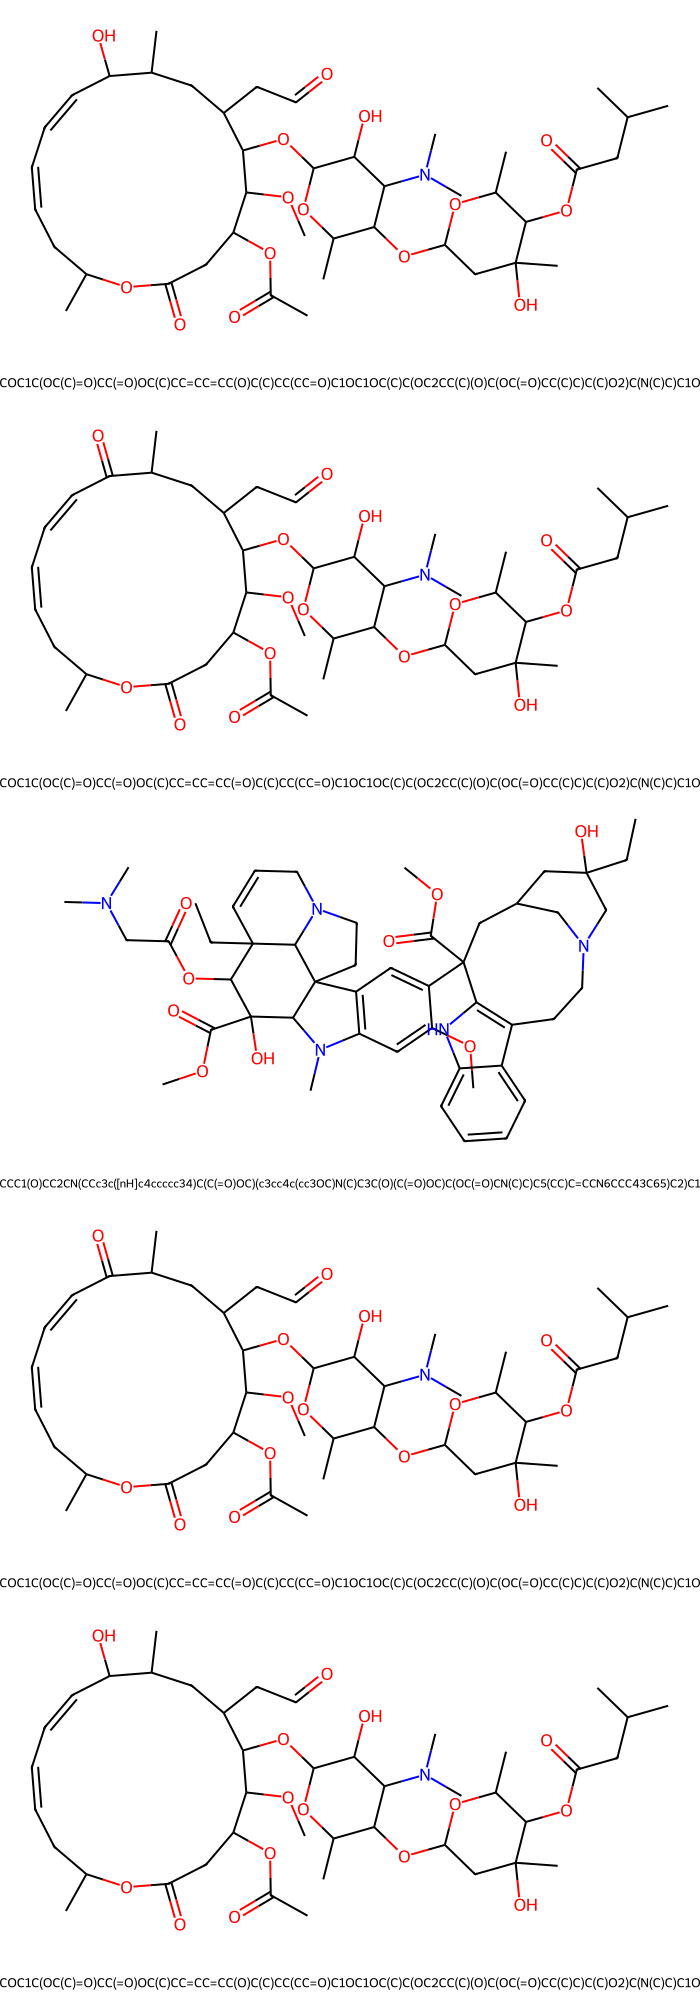

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image

def show_generated_smiles(smiles_list, img_name="generated_molecules.png"):
    # Convert to molecules and filter out invalid ones
    mols = []
    legends = []
    for s in smiles_list:
        mol = Chem.MolFromSmiles(s)
        if mol:
            mols.append(mol)
            legends.append(s)  # You can use SMILES as legend

    # Generate image
    img = Draw.MolsToGridImage(
        mols[:10], molsPerRow=1, subImgSize=(700, 400),
        legends=legends[:10], returnPNG=False
    )

    # Save the image using PIL's .save method
    img.save(img_name)
    display(Image(img_name))
show_generated_smiles(smiles_generated)


In [ ]:
from rdkit.Chem import Descriptors, QED
from rdkit.Chem import Crippen
from rdkit.Chem import Lipinski

def evaluate_properties(smiles_list):
    props = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            mw = Descriptors.MolWt(mol)
            logp = Crippen.MolLogP(mol)
            qed = QED.qed(mol)
            hbd = Lipinski.NumHDonors(mol)
            hba = Lipinski.NumHAcceptors(mol)
            rot_bonds = Lipinski.NumRotatableBonds(mol)

            props.append({
                'SMILES': smi,
                'MolWt': round(mw, 2),
                'logP': round(logp, 2),
                'QED': round(qed, 3),
                'HBD': hbd,
                'HBA': hba,
                'RotBonds': rot_bonds
            })

    return pd.DataFrame(props)

# Run on your generated SMILES
props_df = evaluate_properties(smiles_generated)

# Show the top few
props_df.head(10)


,SMILES,MolWt,logP,QED,HBD,HBA,RotBonds
0,COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(O)C(C)CC(CC=...,828.01,3.01,0.147,3,16,12
1,COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(=O)C(C)CC(CC...,825.99,3.22,0.165,2,16,12
2,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,854.06,3.53,0.164,3,13,9
3,COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(=O)C(C)CC(CC...,825.99,3.22,0.165,2,16,12
4,COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(O)C(C)CC(CC=...,828.01,3.01,0.147,3,16,12


In [ ]:
from rdkit.Chem import Descriptors, QED

def calculate_properties(smiles_list):
    properties = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            props = {
                'SMILES': smi,
                'QED': QED.qed(mol),
                'logP': Descriptors.MolLogP(mol),
                'MolWt': Descriptors.MolWt(mol),
                'HDonors': Descriptors.NumHDonors(mol),
                'HAcceptors': Descriptors.NumHAcceptors(mol),
            }
            props['Lipinski_Violations'] = sum([
                props['MolWt'] > 500,
                props['logP'] > 5,
                props['HDonors'] > 5,
                props['HAcceptors'] > 10
            ])
            properties.append(props)
    return pd.DataFrame(properties)

generated_props_df = calculate_properties(smiles_generated)


In [ ]:
top_qed = generated_props_df.sort_values(by='QED', ascending=False)
display(top_qed.head(10))  # Show top 10 drug-like molecules


,SMILES,QED,logP,MolWt,HDonors,HAcceptors,Lipinski_Violations
1,COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(=O)C(C)CC(CC...,0.164844,3.2216,825.990,2,16,2
3,COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(=O)C(C)CC(CC...,0.164844,3.2216,825.990,2,16,2
2,CCC1(O)CC2CN(CCc3c([nH]c4ccccc34)C(C(=O)OC)(c3...,0.163504,3.5326,854.058,3,13,2
0,COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(O)C(C)CC(CC=...,0.146937,3.0134,828.006,3,16,2
4,COC1C(OC(C)=O)CC(=O)OC(C)CC=CC=CC(O)C(C)CC(CC=...,0.146937,3.0134,828.006,3,16,2


In [ ]:
lipinski_df = generated_props_df[generated_props_df['Lipinski_Violations'] == 0]
print(f"🧪 Molecules passing Lipinski’s Rule: {len(lipinski_df)} / {len(generated_props_df)}")


🧪 Molecules passing Lipinski’s Rule: 0 / 5


In [ ]:
filtered_df = lipinski_df[(lipinski_df['logP'] <= 5) & (lipinski_df['MolWt'] <= 500)]


In [ ]:
filtered_df.to_csv("filtered_generated_molecules.csv", index=False)
print("✅ Exported filtered molecules to CSV.")


✅ Exported filtered molecules to CSV.


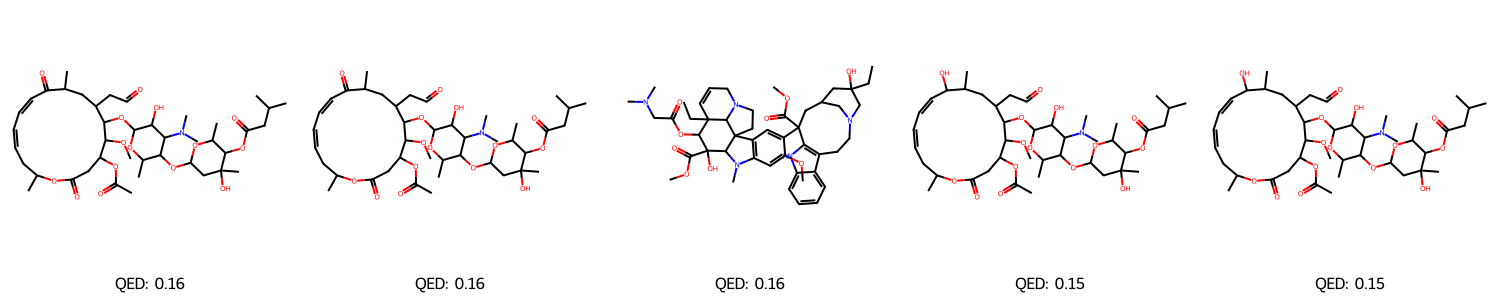

In [ ]:
from rdkit.Chem import Draw

top_mols = [Chem.MolFromSmiles(smi) for smi in top_qed['SMILES'].head(10)]
Draw.MolsToGridImage(top_mols, molsPerRow=5, subImgSize=(300,300),
                     legends=[f"QED: {round(q,2)}" for q in top_qed['QED'].head(10)])


In [ ]:
import numpy as np

np.save("smiles_list.npy", smiles_list)
np.save("fingerprints.npy", fingerprints)


In [ ]:
from google.colab import files

files.download("smiles_list.npy")
files.download("fingerprints.npy")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
from google.colab import files
files.download('model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>